In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import models, transforms, datasets 

In [3]:
CUDA = torch.cuda.is_available()
CUDA

True

In [4]:
device = ('cuda' if CUDA else 'cpu')
device

'cuda'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
os.chdir('/content/drive/My Drive')

In [8]:
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [11]:
transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform = transform)
test_data = datasets.ImageFolder(test_dir, transform = transform)

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


In [12]:
batch_size = 20
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = True)

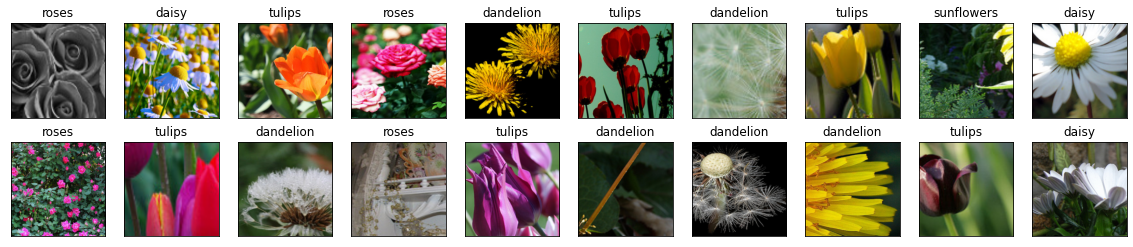

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize = (20, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(classes[labels[idx]])

In [15]:
vgg16 = models.vgg16(pretrained = True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [26]:
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

4096
5


In [34]:
for param in vgg16.features.parameters():
  param.requires_grad = False

In [35]:
import torch.nn as nn
#for the last linear layer which gives 5 op
n_inputs = vgg16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer
vgg16.to(device)

print(vgg16.classifier[6].out_features)

5


In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr = 0.001)

In [49]:
n_epochs = 2
for epoch in range(1, n_epochs + 1):
  train_loss = 0.
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = vgg16(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() 

    #batch starts at 0
    if batch_idx % 20 == 19:
      print('Epoch: %d, Batch: %d, Loss: %.16f' %
            (epoch, batch_idx + 1, train_loss / 20))
      train_loss = 0.


Epoch: 1, Batch: 20, Loss: 0.6523752748966217
Epoch: 1, Batch: 40, Loss: 0.6887903973460198
Epoch: 1, Batch: 60, Loss: 0.7966953173279763
Epoch: 1, Batch: 80, Loss: 0.6740405127406121
Epoch: 1, Batch: 100, Loss: 0.6161471180617809
Epoch: 1, Batch: 120, Loss: 0.7899098858237267
Epoch: 1, Batch: 140, Loss: 0.6689749956130981
Epoch: 2, Batch: 20, Loss: 0.6950439900159836
Epoch: 2, Batch: 40, Loss: 0.7433313369750977
Epoch: 2, Batch: 60, Loss: 0.6882155492901803
Epoch: 2, Batch: 80, Loss: 0.6821728140115738
Epoch: 2, Batch: 100, Loss: 0.6250889226794243
Epoch: 2, Batch: 120, Loss: 0.6742354333400726
Epoch: 2, Batch: 140, Loss: 0.6322893515229225


In [50]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval()

for data, target in test_loader:
  data = data.to(device)
  target = target.to(device)
  output = vgg16(data)
  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.649055

Test Accuracy of daisy: 83% (77/92)
Test Accuracy of dandelion: 74% (98/132)
Test Accuracy of roses: 50% (46/91)
Test Accuracy of sunflowers: 80% (81/101)
Test Accuracy of tulips: 79% (99/124)

Test Accuracy (Overall): 74% (401/540)


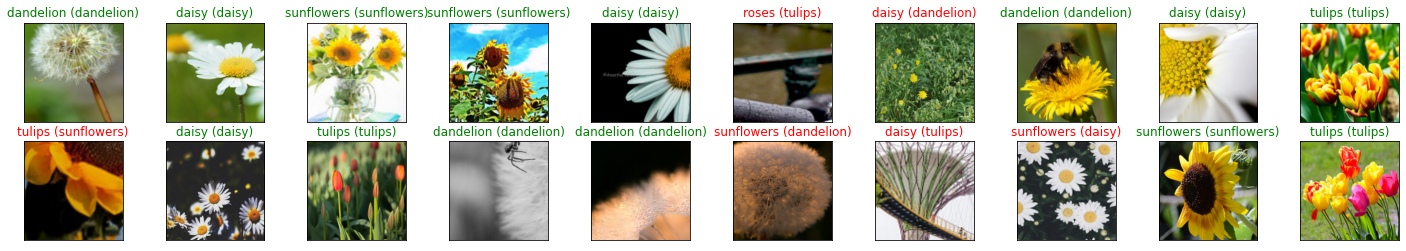

In [53]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()


images = images.to(device)

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
images = images.cpu().numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))